In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

On charge les données en supprimant la première colonne correspondant à l'indice des lignes. Il est bon de noter pour la suite que les 6 premières colonnes restantes sont des données string à ne pas traiter.

In [2]:
X_train = pd.read_csv("X_train.csv").iloc[:,1:]
X_test = pd.read_csv("X_test.csv" ).iloc[:,1:]
y_train = pd.read_csv("y_train.csv").iloc[:,1:]

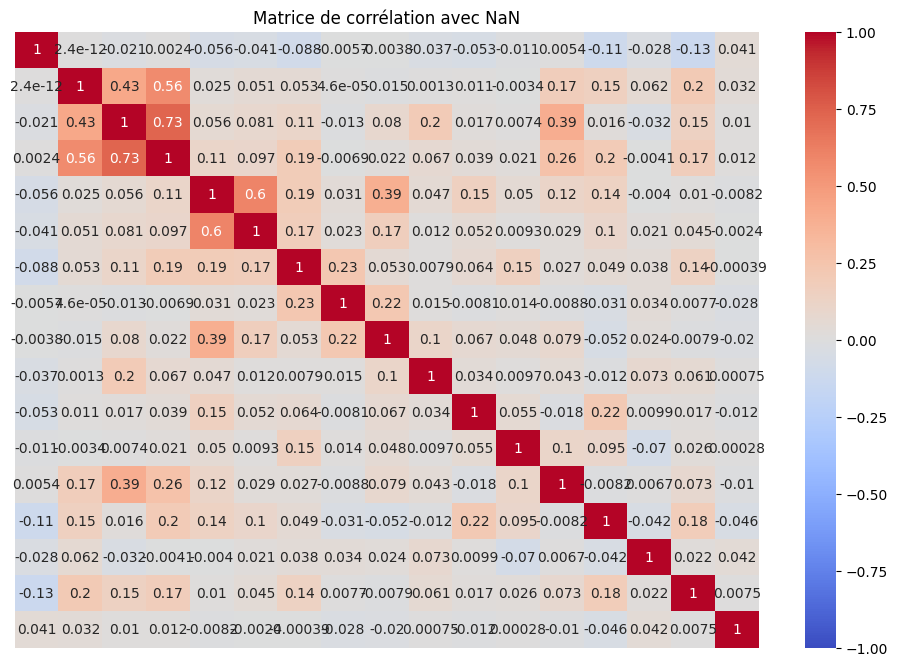

In [3]:
corr_matrice = X_test.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrice, annot=True, cmap='coolwarm', vmin=-1, vmax=1,xticklabels=False, yticklabels=False)
plt.title('Matrice de corrélation avec NaN')
plt.show()

In [4]:
def nrmse(y_true, y_pred) :
    """Fonction calculant l'erreur NRMSE utilisée pour classer les différents résultats du Data Challenge"""
    nrmse = np.array([])
    for col in y_true.columns :
        erreur = np.array([])
        for elem_true,elem_pred in y_true[col],y_pred[col] :
            erreur.append(elem_true-elem_pred)
        rmse = np.sqrt((erreur**2).mean())
        value_range = y_true[col].max() - y_true[col].min()
        nrsme.append(rmse/value_range)
    return(nrmse.mean())

# Méthode n°1 : Imputation Itérative

In [5]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [6]:
X_train_1 = X_train.values
y_train_1 = y_train.values
X_test_1 = X_test.values

In [7]:
IT = IterativeImputer(max_iter = 10, missing_values=np.nan);
IT.fit(X_train_1[:,6:], y_train_1[:,6:]);

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/impute/_iterative.py:713: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


On remarque un avertissement : le modele n'a pas le temps de converger, cela se produit même si on augmente le nombre d'itérations.

In [8]:
col = ['anonimized_id','company_id','year','region','headquarters_country', 
       'industry', 'market_cap', 'employees', 'revenue', 'scope_1', 'scope_2',
       'scope_3', 'waste_production', 'waste_recycling', 'water_consumption',
       'water_withdrawal', 'energy_consumption', 'hours_of_training',
       'gender_pay_gap', 'independent_board_members_percentage',
       'legal_costs_paid_for_controversies', 'ceo_compensation']

In [9]:
y_test_1 = pd.DataFrame(np.concatenate( (X_test_1[:,:6],IT.transform(X_test_1[:,6:])), axis = 1))
y_test_1.columns = col
y_test_1.to_csv('y_test_1',index = True, index_label=True)
#score = 0.555

y_test_1.head()

,anonimized_id,company_id,year,region,headquarters_country,industry,market_cap,employees,revenue,scope_1,...,waste_production,waste_recycling,water_consumption,water_withdrawal,energy_consumption,hours_of_training,gender_pay_gap,independent_board_members_percentage,legal_costs_paid_for_controversies,ceo_compensation
0,0fc16315-00da-4223-9cd5-0b09f6274aeb_2020,0fc16315-00da-4223-9cd5-0b09f6274aeb,2020,United States and Canada,United States,Systems Software,1746936.59,180599.732437,125824.6,118100.0,...,77063.0,50558.0,3966639.9,7505081.0,10757200.000861,-9233863.563556,27.461047,0.91667,413.240268,12012916.6531
1,0fc16315-00da-4223-9cd5-0b09f6274aeb_2019,0fc16315-00da-4223-9cd5-0b09f6274aeb,2019,United States and Canada,United States,Systems Software,1746936.59,432072.581431,243678.578078,113412.0,...,26927.0,14368.0,4215390.1,-749949996.274499,9227990.000738,-9942884.929625,32.400133,0.85714,875.774401,14456049.659783
2,0fc16315-00da-4223-9cd5-0b09f6274aeb_2018,0fc16315-00da-4223-9cd5-0b09f6274aeb,2018,United States and Canada,United States,Systems Software,1746936.59,131000.0,239777.47963,90723.0,...,19066.0,-936197.74219,3614310.1,-250991867.207567,7955320.000636,-14131681.271436,30.53912,0.85714,727.193678,3716046.484476
3,1ac37bea-30f0-48cc-971e-4128bb321565_2020,1ac37bea-30f0-48cc-971e-4128bb321565,2020,United States and Canada,United States,Interactive Media and Services,1292666.99,135301.0,160587.25,38694.0,...,24784326.624792,-636105.621659,14200757.58,21549242.42,630355580.151481,-8360908.887287,21.098472,0.580322,304.098226,7425547.0
4,1ac37bea-30f0-48cc-971e-4128bb321565_2019,1ac37bea-30f0-48cc-971e-4128bb321565,2019,United States and Canada,United States,Interactive Media and Services,1292666.99,118899.0,142401.79,66686.0,...,-27813184.269176,-1888096.618086,12924242.42,19549242.42,12749458.0,45695606.90356,34.055306,0.007273,1493.02,280621552.0


Problème : on a des valeurs abberrantes (extrêmes ou négatives)

# Méthode n°2 : Imputation Iterative avec remplacement des valeurs aberrantes

## 2.1. : Premier remplacement par la médiane pour les valeurs extrêmes et négatives

On determine les valeurs extrêmes grace à 'threshold' et les valeurs négatives grace à 'negative'.

On considère qu'une valeur est "extrême" si elle n'appartient pas au 95ème centile.

In [10]:
y_test_2 = y_test_1.values
y_test_2_float = y_test_2[:,6:]

threshold = np.percentile(y_test_2_float, 95, axis = 0)

outliers = (threshold < y_test_2_float)  
negative = (y_test_2_float < 0)

On les remplace par la médiane.

In [11]:
median = np.median(y_test_2_float, axis = 0)
y_test_2_float = np.where(outliers, median, y_test_2_float)
y_test_2_float = np.where(negative, median, y_test_2_float)

Résultats : 

In [12]:
y_test_2_res = pd.DataFrame(np.concatenate((y_test_2[:, :6], y_test_2_float), axis=1), columns=col)
y_test_2_res.to_csv('y_test_2',index = True, index_label=True)
#score = 0,265

Problème : Les valeurs négatives ont un impact trop important sur la médiane. Il est bon de remarquer aussi que les 6 autres premières colonnes sont des données string à ne pas traiter.

## 2.2. : Calcul de la médiane sans les valeurs aberrantes

Dans ce paragraphe on ne remplace que les valeurs négatives, pas les valeurs extrêmes.

In [13]:
y_test_3 = y_test_1.values
y_test_3_float = y_test_2[:,6:]

In [14]:
y_test_3_float = np.where(negative, np.nan, y_test_3_float)
median = np.nanmedian(y_test_3_float, axis = 0)
y_test_3_float = np.where(negative, median, y_test_3_float)

In [15]:
y_test_3_res = pd.DataFrame( np.concatenate( (y_test_3[:,:6], y_test_3_float),axis = 1 ), columns = col )
y_test_3_res.to_csv('y_test_3',index = True, index_label=True)
#score = 0.319

# 2.3. : Etude des valeurs trop élevées

Question : Y'a t-il beaucoup de valeurs extrêmes qui sont du à IterativeImputer ou bien sont-elles déjà présentes dans X_test initialement ?

In [16]:
X_test_1_float = X_test.values[:,6:]

outliers_init = threshold < X_test_1_float
n,p = np.shape(outliers)

pareil = ((outliers == outliers_init)&(outliers))
print(np.sum(pareil)/(np.sum((outliers))))

0.43478260869565216
/tmp/ipykernel_229/843440762.py:3: RuntimeWarning: invalid value encountered in less
  outliers_init = threshold < X_test_1_float


43% des valeurs extrêmes sont déjà présentes dans X_test. 57% des valeurs extrêmes sont donc créées par les imputations itératives. Tentons de remplacer uniquement celle-ci par la médiane.

### On décide donc de remplacer les valeurs extrêmes créées par les imputations itératives par les médianes.

On reprend y_test_3 car les valeurs négatives y sont déjà remplacés. On calcule les nouvelles médianes sans prendre en compte les valeurs extrêmes créées par IterativeImputer

In [17]:
outliers_ii = ((outliers)&(~outliers_init)) #outliers créés par les imputations itératives
y_test_4_float = np.copy(y_test_3_float)
y_test_4_float = np.where(outliers_ii, np.nan, y_test_4_float)
median_4 = np.nanmedian(y_test_4_float, axis = 0)
y_test_4_float = np.where(outliers_ii, median_4, y_test_4_float)

In [18]:
y_test_4_res = pd.DataFrame( np.concatenate( (y_test_3[:,:6], y_test_4_float),axis = 1 ), columns = col )
y_test_4_res.to_csv('y_test_4',index = True, index_label=True)
#score = 0.2502

Il se peut néanmoins que les outliers créés par IterativeImputer soient légitimes. Nous imaginons qu'il est possible de s'intéresser à ceci avec la matrice de corrélation mais nous n'étions pas sûr de comment entreprendre cette idée sans gaspiller trop de temps.

Nous avons aussi eu l'idée de changer notre définition des valeurs extrêmes en changeant de centile, mais étant donné que nous étions limité à deux soumissions de solution par jour, tester plusieurs centiles était compliqué. 

# Méthode 3 : Imputation à la main

In [19]:
X_test_6_float = (X_test.iloc[:,6:]).values

On calcule les médianes et on remplace les valeurs à imputer par ces médianes.

In [20]:
median = np.nanmedian(X_test_6_float, axis=0)
NAN = np.isnan(X_test_6_float)
X_test_6_float = np.where(NAN, median, X_test_6_float)

On prépare la matrice de corrélation, car on souhaite imputer une colonne en utilisant la colonne avec laquelle elle est la plus corrélée. 

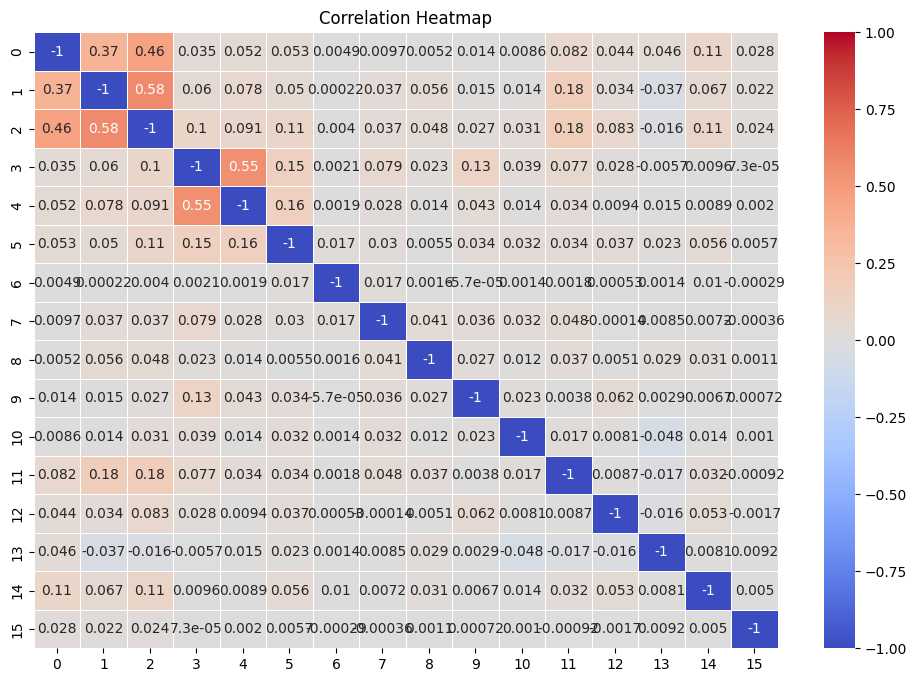

In [21]:
matrice_corr = np.corrcoef(X_test_6_float, rowvar=False)
np.fill_diagonal(matrice_corr, -1) #sinon pas possible de trouver le max 
plt.figure(figsize=(12,8))

sns.heatmap(matrice_corr,annot=True, vmin = -1, vmax = 1, cmap="coolwarm", linewidths=.5)
plt.title("Correlation Heatmap")
plt.show()

## 6.1. : imputation avec régression linéaire

In [22]:
from sklearn.linear_model import LinearRegression

In [23]:
res_reg_lin = np.copy(X_test_6_float)
for i in range(len(matrice_corr)):
    if np.sum(NAN[:,i] > 0): #sinon rien à imputer
        #choix de la colonne servant de X
        ind_corr = np.argmax(matrice_corr[i])

        #Implementation modele 
        reg = LinearRegression();
        X_train_bis = ((res_reg_lin[:,ind_corr])[~NAN[:,i]]).reshape(-1,1)
        y_train_bis = ((res_reg_lin[:,i])[~NAN[:,i]]).reshape(-1,1)
        reg.fit(X_train_bis, y_train_bis);

        #prediction
        X_test_bis = ((res_reg_lin[:,ind_corr])[NAN[:,i]]).reshape(-1,1)
        (res_reg_lin[:,i])[NAN[:,i]] = np.reshape((reg.predict(X_test_bis)),(1,-1))[0]

On traite comme précédemment les valeurs extrêmes et négatives.

In [24]:
def traitement(matrice) : 
    '''
    Traite les résultats brut pour supprimer les valeurs extremes et négatives comme explpiqué plus haut
    '''
    threshold = np.percentile(matrice, 95, axis = 0)
    outliers = (threshold < matrice)  
    outliers_init = threshold < X_test_1_float
    outliers_ii = ((outliers)&(~outliers_init))

    negative = (matrice < 0)

    matrice = np.where(outliers_ii|negative, np.nan, matrice)
    median = np.nanmedian(matrice, axis = 0)
    matrice = np.where(outliers_ii|negative, median_4, matrice)
    return(matrice)

In [25]:
def resultat(matrice, nom): 
    '''
    Met en forme les résultats pour pouvoir les soumettre à évaluation 
    '''
    matrice = pd.DataFrame( np.concatenate( (y_test_3[:,:6], matrice),axis = 1 ), columns = col )
    matrice.to_csv(nom,index = True, index_label=True)
    return(matrice)

In [26]:
res_reg_lin = resultat(traitement(res_reg_lin), 'res_reg_lin')
#score = 0.28976447846883313 

/tmp/ipykernel_229/4137952012.py:7: RuntimeWarning: invalid value encountered in less
  outliers_init = threshold < X_test_1_float


## 6.2. : Imputation avec random forest

In [27]:
from sklearn.ensemble import RandomForestRegressor

In [28]:
res_RF = np.copy(X_test_6_float)
for i in range(len(matrice_corr)):
    if np.sum(NAN[:,i]) > 0: #sinon rien à imputer
        #choix de la colonne servant de X
        ind_corr = np.argmax(matrice_corr[i])

        #Implementation modele 
        RF = RandomForestRegressor(n_estimators = 10, max_features = 4, random_state = 0);
        X_train_bis = ((res_RF[:,ind_corr])[~NAN[:,i]]).reshape(-1,1)
        y_train_bis = ((res_RF[:,i])[~NAN[:,i]])
        RF.fit(X_train_bis, y_train_bis);

        #prediction
        X_test_bis = ((res_RF[:,ind_corr])[NAN[:,i]]).reshape(-1,1)
        ((res_RF[:,ind_corr])[NAN[:,i]]) = RF.predict(X_test_bis)

In [29]:
res_RF = resultat(traitement(res_RF), 'res_RF')
#score = 0.45

/tmp/ipykernel_229/4137952012.py:7: RuntimeWarning: invalid value encountered in less
  outliers_init = threshold < X_test_1_float


Nous nous sommes rendus compte à la fin que faire un random forest avec une seule feature perdait de son intêret.

## 6.3. : Random Forest avec plus de features

In [30]:
res_RF2 = np.copy(X_test_6_float)
for i in range(len(matrice_corr)):
    if np.sum(NAN[:,i]) > 0: #sinon rien à imputer
        #Implementation modele 
        RF = RandomForestRegressor(n_estimators = 10, max_features = 4, random_state = 0);
        X_train_bis = np.delete(res_RF2,i,axis = 1 )[~NAN[:,i]]
        y_train_bis = res_RF2[:,i][~NAN[:,i]]
        RF.fit(X_train_bis, y_train_bis);

        #prediction
        X_test_bis = ((np.delete(res_RF2,i,axis = 1 ))[NAN[:,i]]).reshape(-1,1)
        res_RF2[:,i][NAN[:,i]] = RF.predict(np.delete(res_RF2,i,axis = 1 )[NAN[:,i]])

In [31]:
res_RF2 = resultat(traitement(res_RF2), 'res_RF2')
#score = 0.1682293476600787

/tmp/ipykernel_229/4137952012.py:7: RuntimeWarning: invalid value encountered in less
  outliers_init = threshold < X_test_1_float


### 6.4. : Random Forest avec des itérations 

In [32]:
res_RF3 = np.copy(X_test_6_float)
limite_c = 0.10
convergence = 1
nbIter = 0
while ((convergence > limite_c)&(nbIter<20)):
    ancien_RF3 = np.copy(res_RF3)
    for i in range(len(matrice_corr)):
        if np.sum(NAN[:,i] > 0): #sinon rien à imputer
            #Implementation modele 
            RF = RandomForestRegressor(n_estimators = 10, max_features = 4, random_state = 0);
            X_train_bis = np.delete(res_RF3,i,axis = 1 )[~NAN[:,i]]
            y_train_bis = res_RF3[:,i][~NAN[:,i]]
            RF.fit(X_train_bis, y_train_bis);

            #prediction
            X_test_bis = ((np.delete(res_RF3,i,axis = 1 ))[NAN[:,i]]).reshape(-1,1)
            res_RF3[:,i][NAN[:,i]] = RF.predict(np.delete(res_RF3,i,axis = 1 )[NAN[:,i]])
            res_RF3 = traitement(res_RF3) # on retransforme les données avant de reparcourir le dataframe
    convergence = np.sum((res_RF3-ancien_RF3)**2)/(len(res_RF3)*len(res_RF3[1]))
    print(convergence)
    nbIter += 1

/tmp/ipykernel_229/4137952012.py:7: RuntimeWarning: invalid value encountered in less
  outliers_init = threshold < X_test_1_float
/tmp/ipykernel_229/4137952012.py:7: RuntimeWarning: invalid value encountered in less
  outliers_init = threshold < X_test_1_float
/tmp/ipykernel_229/4137952012.py:7: RuntimeWarning: invalid value encountered in less
  outliers_init = threshold < X_test_1_float
/tmp/ipykernel_229/4137952012.py:7: RuntimeWarning: invalid value encountered in less
  outliers_init = threshold < X_test_1_float
/tmp/ipykernel_229/4137952012.py:7: RuntimeWarning: invalid value encountered in less
  outliers_init = threshold < X_test_1_float
/tmp/ipykernel_229/4137952012.py:7: RuntimeWarning: invalid value encountered in less
  outliers_init = threshold < X_test_1_float
/tmp/ipykernel_229/4137952012.py:7: RuntimeWarning: invalid value encountered in less
  outliers_init = threshold < X_test_1_float
/tmp/ipykernel_229/4137952012.py:7: RuntimeWarning: invalid value encountered in le

La convergence augmente jusqu'à atteindre un palier, il est donc logique qu'on ne puisse pas améliorer le score. Il faudrait tester terme par terme pour voir comment cela évolue.

In [33]:
res_RF3 = resultat(traitement(res_RF3), 'res_RF3')
#score = 0.1753

/tmp/ipykernel_229/4137952012.py:7: RuntimeWarning: invalid value encountered in less
  outliers_init = threshold < X_test_1_float


## 6.4. : RF en utilisant les train

In [34]:
#traitement du train
y_train_float = (y_train.iloc[:,6:]).values
NAN_train = np.isnan(y_train_float)
median_train = np.nanmedian(y_train_float, axis = 0)
y_train_float = np.where(NAN_train, median_train, y_train_float)

In [35]:
res_RF4 = np.copy(X_test_6_float)
for i in range(len(matrice_corr)):
    if np.sum(NAN[:,i]) > 0: #sinon rien à imputer
        #Implementation modele 
        RF = RandomForestRegressor(n_estimators = 10, max_features = 4, random_state = 0);
        X_train_bis = np.concatenate( (np.delete(res_RF4,i,axis = 1 )[~NAN[:,i]] , np.delete(y_train_float,i,axis=1)[~NAN_train[:,i]] ) , axis =0 )
        y_train_bis = np.concatenate( (res_RF4[:,i][~NAN[:,i]], y_train_float[:,i][~NAN_train[:,i]]), axis = 0)
        RF.fit(X_train_bis, y_train_bis);

        #prediction
        X_test_bis = ((np.delete(res_RF4,i,axis = 1 ))[NAN[:,i]]).reshape(-1,1)
        res_RF4[:,i][NAN[:,i]] = RF.predict(np.delete(res_RF4,i,axis = 1 )[NAN[:,i]])

In [36]:
res_RF4 = resultat(traitement(res_RF4), 'res_RF4')
#score =  0,1660089579485171

/tmp/ipykernel_229/4137952012.py:7: RuntimeWarning: invalid value encountered in less
  outliers_init = threshold < X_test_1_float


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a8554869-07fd-4ff5-ad1f-586af4c74b8c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>